## Prelude

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['Noto Sans CJK SC']

## 实现 KMeans 算法

In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_random_state

from typing import NamedTuple


class MyKMeans(BaseEstimator, ClusterMixin):
    class ClusteringResult(NamedTuple):
        cluster_centers: np.ndarray
        labels: np.ndarray
        dist_to_centers: np.ndarray

    def __init__(self, n_clusters, random_state=None, max_iter=300, tolerance=1e-4):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter
        self.tolerance = tolerance

    @staticmethod
    def __get_label_with_min_distance(x: np.ndarray, centers: np.ndarray):
        assert x.ndim == 1
        assert centers.ndim == 2
        assert x.shape[0] == centers.shape[1]

        ecud_dist = np.linalg.norm(centers - x, axis=1)
        min_index = np.argmin(ecud_dist)
        return np.array([min_index, ecud_dist[min_index]])

    @staticmethod
    def __get_cluster_result(
        X: np.ndarray, centers: np.ndarray, count: int, tolerance: float
    ):
        assert X.ndim == 2
        assert centers.ndim == 2
        assert X.shape[1] == centers.shape[1]

        label_min_dist = np.apply_along_axis(
            MyKMeans.__get_label_with_min_distance, 1, X, centers
        )

        labels = label_min_dist[:, 0]
        min_dists = label_min_dist[:, 1]

        X_label = np.column_stack((X, label_min_dist[:, 0]))
        X_label_df = pd.DataFrame(X_label)
        new_cluster_centers = (
            X_label_df.groupby(X_label_df.columns[-1]).agg("mean").values
        )

        center_diffs = np.linalg.norm(centers - new_cluster_centers, axis=1)

        if np.all(center_diffs < tolerance) or count == 1:
            return MyKMeans.ClusteringResult(new_cluster_centers, labels, min_dists)
        else:
            return MyKMeans.__get_cluster_result(
                X, new_cluster_centers, count - 1, tolerance
            )

    def fit(self, X, y=None):
        self.random_state_ = check_random_state(self.random_state)
        init_center_indices = self.random_state_.choice(
            X.shape[0], self.n_clusters, replace=False
        )
        init_centers = X[init_center_indices]
        clustering_result = MyKMeans.__get_cluster_result(
            X, init_centers, 100, self.tolerance
        )
        self.cluster_centers_ = clustering_result.cluster_centers
        self.interia_ = np.sum(clustering_result.dist_to_centers**2)
        self.labels_ = clustering_result.labels
        return self

## 使用K-Means算法对身高-体重数据进行聚类

In [3]:
height_weight_df = pd.DataFrame(
    [
        [170, 70],
        [178, 75],
        [100, 100],
        [120, 40],
        [10, 0.1],
    ],
    columns=["身高（cm）", "体重（kg）"],
    index=["A", "B", "C", "D", "E"],
)

height_weight_df

,身高（cm）,体重（kg）
A,170,70.0
B,178,75.0
C,100,100.0
D,120,40.0
E,10,0.1


### 分为2类

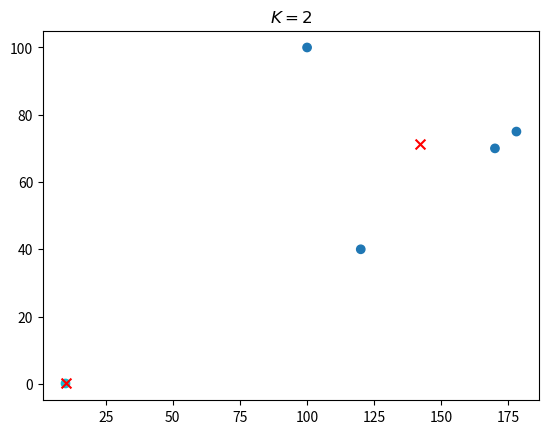

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler_k2 = StandardScaler()
my_kmeans_k2 = MyKMeans(n_clusters=2, random_state=42)

labels2 = make_pipeline(scaler_k2, my_kmeans_k2).fit_predict(height_weight_df)


scatter = plt.scatter(
    height_weight_df["身高（cm）"],
    height_weight_df["体重（kg）"],
    c=labels2,
    cmap="tab10",
)

cluster_centers_k2 = scaler_k2.inverse_transform(my_kmeans_k2.cluster_centers_)

plt.scatter(
    cluster_centers_k2[:, 0],
    cluster_centers_k2[:, 1],
    c="red",
    s=50,
    marker="x",
)

plt.title("$K = 2$")
plt.savefig("figures/height_weight_k2.png", dpi=300)

plt.show()

### 分为3类

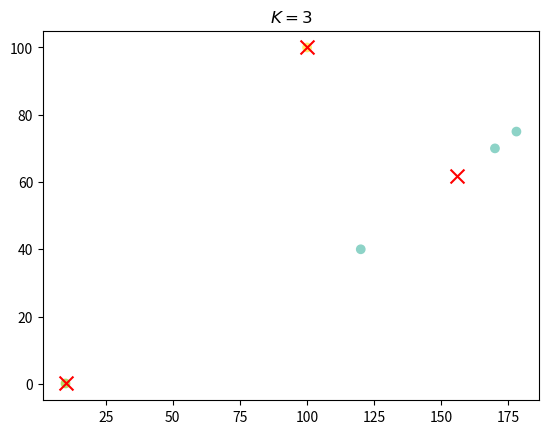

In [5]:
scaler_k3 = StandardScaler()
my_kmeans_k3 = MyKMeans(n_clusters=3, random_state=42)

labels3 = make_pipeline(scaler_k3, my_kmeans_k3).fit_predict(height_weight_df)


plt.scatter(
    height_weight_df["身高（cm）"],
    height_weight_df["体重（kg）"],
    c=labels3,
    cmap="Set3",
)

cluster_centers_k3 = scaler_k3.inverse_transform(my_kmeans_k3.cluster_centers_)

plt.scatter(
    cluster_centers_k3[:, 0],
    cluster_centers_k3[:, 1],
    c="red",
    s=100,
    marker="x",
)

plt.title("$K = 3$")
plt.savefig("figures/height_weight_k3.png", dpi=300)

plt.show()


## 对 Iris 数据集进行聚类

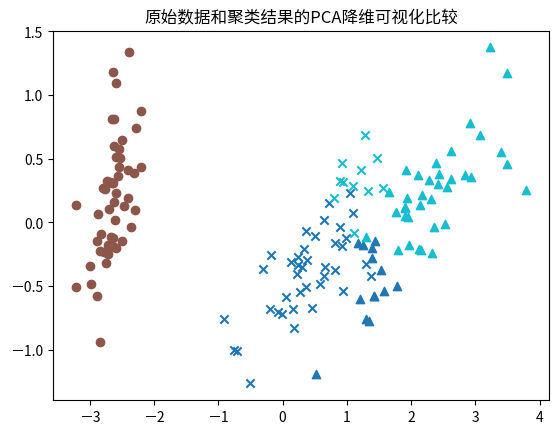

In [6]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_iris, y_iris = load_iris(return_X_y=True)

iris_cluster_labels = make_pipeline(
    StandardScaler(), KMeans(n_clusters=3, random_state=42, n_init=10)
).fit_predict(X_iris)

X_iris_pca = PCA(n_components=2).fit_transform(X_iris)

iris_df = pd.DataFrame(
    np.column_stack((X_iris_pca, iris_cluster_labels, y_iris)),
    columns=["N1", "N2", "Cluster", "Actual"],
)

tab10_cmap = plt.get_cmap("tab10")
markers = ["o", "x", "^"]
colors = [tab10_cmap(i) for i in np.linspace(0, 1, 3)]

for (cluster, actual_label), df in iris_df.groupby(["Cluster", "Actual"]):
    scatter_color = colors[int(cluster)]
    scatter_marker = markers[int(actual_label)]
    plt.scatter(df["N1"], df["N2"], color=scatter_color, marker=scatter_marker)

plt.title("原始数据和聚类结果的PCA降维可视化比较")
plt.savefig("figures/iris_pca.png", dpi=300)

plt.show()


## 使用 KMeans 算法对给定数据进行聚类分析

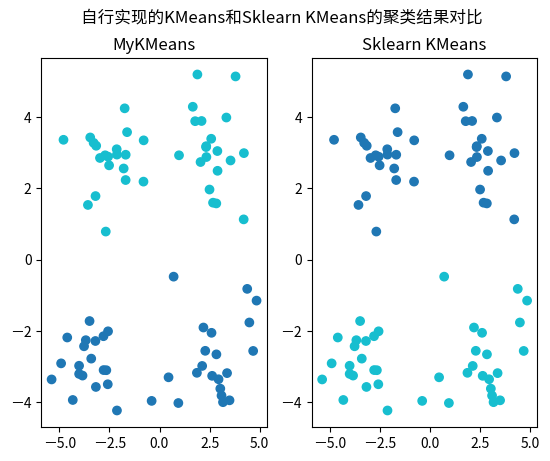

In [7]:
test_data = np.loadtxt("TESTDATA.TXT", delimiter="\t")

labels_my_kmeans = make_pipeline(
    StandardScaler(), MyKMeans(n_clusters=2, random_state=42)
).fit_predict(test_data)

labels_sk_kmeans = make_pipeline(
    StandardScaler(), KMeans(n_clusters=2, random_state=42, n_init=10)
).fit_predict(test_data)

plt.subplot(1, 2, 1)
plt.scatter(test_data[:, 0], test_data[:, 1], c=labels_my_kmeans, cmap="tab10")
plt.title("MyKMeans")

plt.subplot(1, 2, 2)
plt.scatter(test_data[:, 0], test_data[:, 1], c=labels_sk_kmeans, cmap="tab10")
plt.title("Sklearn KMeans")

plt.suptitle("自行实现的KMeans和Sklearn KMeans的聚类结果对比")
plt.savefig("figures/test_data_kmeans.png", dpi=300)

plt.show()


In [8]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report

X_digits, y_digits = load_digits(return_X_y=True)

digits_clusters = KMeans(
    n_clusters=10,
    random_state=42,
    n_init="auto",
    max_iter=1000,
).fit_predict(X_digits)

digits_data_clustered = np.column_stack((X_digits, y_digits, digits_clusters))

# 以每个簇出现次数最多的数字作为该簇的标签
cluster_map = {}

for i in range(10):
    cluster_map[i] = np.argmax(
        np.bincount(
            digits_data_clustered[digits_data_clustered[:, -1] == i, -2].astype(int)
        )
    )

digits_data_clustered[:, -1] = np.vectorize(cluster_map.get)(
    digits_data_clustered[:, -1]
)

print(classification_report(digits_data_clustered[:, -2], digits_data_clustered[:, -1]))


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       178
         1.0       0.78      0.71      0.74       182
         2.0       0.84      0.82      0.83       177
         3.0       0.92      0.87      0.89       183
         4.0       0.96      0.88      0.92       181
         5.0       0.94      0.75      0.84       182
         6.0       0.97      0.97      0.97       181
         7.0       0.88      0.94      0.91       179
         8.0       0.79      0.78      0.79       174
         9.0       0.65      0.89      0.75       180

    accuracy                           0.86      1797
   macro avg       0.87      0.86      0.86      1797
weighted avg       0.87      0.86      0.86      1797

